In [1]:
import numpy as np
import pandas as pd



In [2]:
toyota = pd.read_csv('/Users/yixuanwang/Desktop/ucb_21/IEOR_142/hw1/RAV4-142-Spring2021.csv')
toyota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MonthNumeric  120 non-null    int64  
 1   MonthFactor   120 non-null    object 
 2   Year          120 non-null    int64  
 3   RAV4Sales     120 non-null    int64  
 4   Unemployment  120 non-null    float64
 5   RAV4Queries   120 non-null    int64  
 6   CPIAll        120 non-null    float64
 7   CPIEnergy     120 non-null    float64
dtypes: float64(3), int64(4), object(1)
memory usage: 7.6+ KB


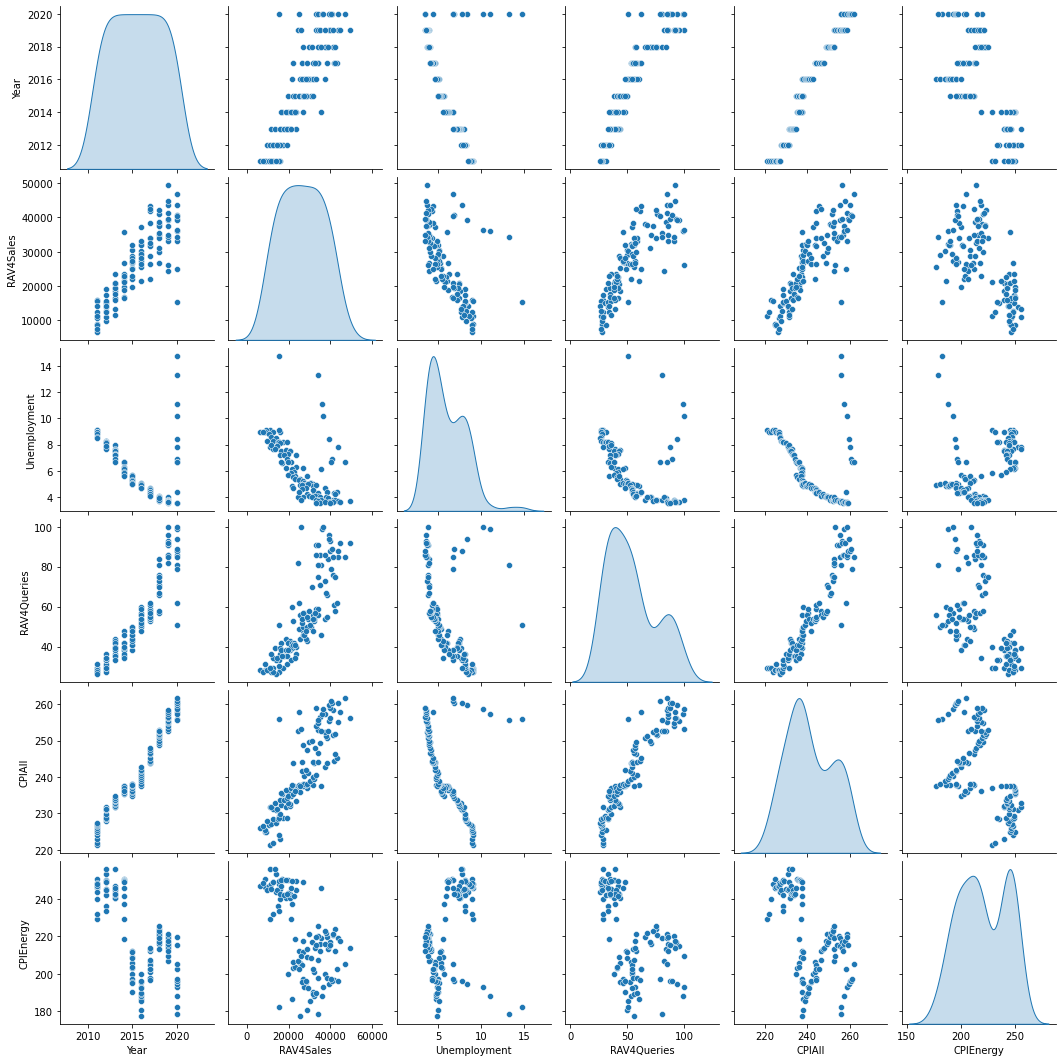

In [3]:
import seaborn as sns

sns.pairplot(toyota.iloc[:,1:9],diag_kind='kde')

In [4]:
toyota.corr()

,MonthNumeric,Year,RAV4Sales,Unemployment,RAV4Queries,CPIAll,CPIEnergy
MonthNumeric,1.000000,0.000000,0.227004,-0.057227,0.061450,0.116042,0.001460
Year,0.000000,1.000000,0.855281,-0.496702,0.926589,0.979937,-0.699379
RAV4Sales,0.227004,0.855281,1.000000,-0.614960,0.839585,0.851416,-0.623119
Unemployment,-0.057227,-0.496702,-0.614960,1.000000,-0.461134,-0.468943,0.337566
RAV4Queries,0.061450,0.926589,0.839585,-0.461134,1.000000,0.940339,-0.559503
CPIAll,0.116042,0.979937,0.851416,-0.468943,0.940339,1.000000,-0.576000
CPIEnergy,0.001460,-0.699379,-0.623119,0.337566,-0.559503,-0.576000,1.000000


### Start by splitting the data into a training set and testing set. The training set should contain all observations for 2011 through 2016. The testing set should have all observations for 2017 through 2020.

Consider just the four independent variables Unemployment, RAV4Queries, CPIEnergy, and CPI- All. Using your regression skills, select a subset of these four variables and construct a regression model to predict monthly RAV4 sales (RAV4Sales). Try to choose which of the four variables to use in your model in order to build a high-quality linear regression model. Use the training set to build your model, and do not add any additional variables beyond the four indicated independent variables. Write a brief explanation (no more than one page, preferably less) – targeted to a statistically literate manager – describing how you decided on the variables to use in the model and the quality of the linear regression model’s predictions, as evaluated using the training set (there is no need to consider the test set for this part of the problem). Be sure to address the following in your explanation:

In [5]:
training_set = toyota[toyota['Year'] <= 2016]
test_set = toyota[toyota['Year'] > 2016]

len(training_set), len(test_set)

(72, 48)

### i) What is the linear regression equation produced by your model, and how should one interpret the coefficients for the independent variables? Consider interpretability issues when writing down the equation (e.g., do not just copy and paste the output from Python).


In [6]:
# Import the library that contains all the functions/modules related to the regression model
import statsmodels.api as sm

# Choose the features to be used
x_train = training_set[['Unemployment','RAV4Queries','CPIEnergy','CPIAll']]
y_train = training_set['RAV4Sales']

# We must add an intercept as the standard model doesn't automatically fit one
x_train = sm.add_constant(x_train)

# Fit the data to the model
model1 = sm.OLS(y_train, x_train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              RAV4Sales   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     71.42
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           1.93e-23
Time:                        17:30:45   Log-Likelihood:                -683.31
No. Observations:                  72   AIC:                             1377.
Df Residuals:                      67   BIC:                             1388.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.961e+04   9.36e+04      0.210   

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

cols = ['Unemployment', 'RAV4Queries','CPIEnergy','CPIAll']
VIF(training_set, cols)

Unemployment    37.437684
RAV4Queries      6.231404
CPIEnergy        7.220536
CPIAll          28.216088
dtype: float64

In [8]:
import matplotlib.pyplot as plt
def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

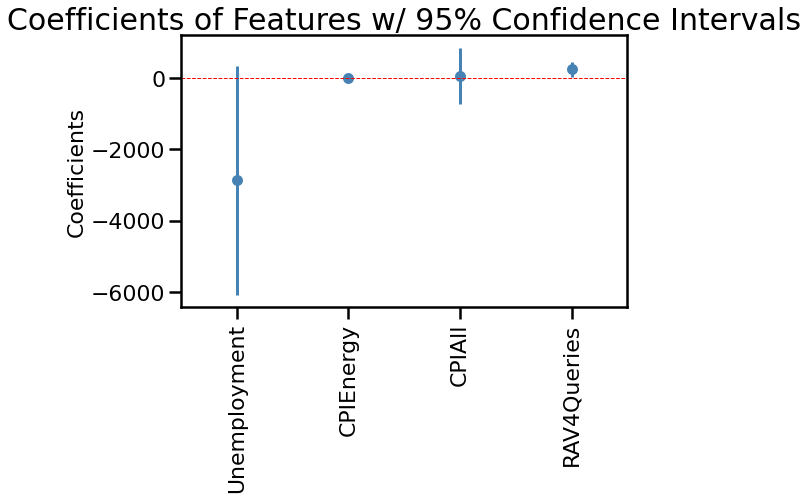

In [9]:
coefplot(model1)


## Remove the variables with high VIFs. Stop until p value is small enough ( <0.05 )

### ii) How did you select the variables to include in your linear regression model?

Remmove Unemployment



In [10]:
# calculate Variance Inflation Factor for each explanatory variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

# The dataframe passed to VIF must include the intercept term. We add it the same way we did before.
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

cols = ['RAV4Queries','CPIEnergy','CPIAll']
VIF(training_set, cols)

RAV4Queries    5.952056
CPIEnergy      2.610675
CPIAll         3.876882
dtype: float64

In [11]:
# Import the library that contains all the functions/modules related to the regression model
import statsmodels.api as sm

# Choose the features to be used
x_train = training_set[['RAV4Queries','CPIEnergy','CPIAll']]
y_train = training_set['RAV4Sales']

# We must add an intercept as the standard model doesn't automatically fit one
x_train = sm.add_constant(x_train)

# Fit the data to the model
model1 = sm.OLS(y_train, x_train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              RAV4Sales   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     91.21
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           8.73e-24
Time:                        17:30:46   Log-Likelihood:                -684.99
No. Observations:                  72   AIC:                             1378.
Df Residuals:                      68   BIC:                             1387.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.379e+05   3.21e+04     -4.290      


### iii) Do the signs of the model’s coefficients make sense? Are you reasonably sure that the signs are correct?



In [12]:
import matplotlib.pyplot as plt
def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

In [13]:
# calculate Variance Inflation Factor for each explanatory variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

# The dataframe passed to VIF must include the intercept term. We add it the same way we did before.
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

cols = ['RAV4Queries','CPIEnergy','CPIAll']
VIF(training_set, cols)

RAV4Queries    5.952056
CPIEnergy      2.610675
CPIAll         3.876882
dtype: float64

In [14]:
# Import the library that contains all the functions/modules related to the regression model
import statsmodels.api as sm

# Choose the features to be used
x_train = training_set[['CPIEnergy','CPIAll']]
y_train = training_set['RAV4Sales']

# We must add an intercept as the standard model doesn't automatically fit one
x_train = sm.add_constant(x_train)

# Fit the data to the model
model1 = sm.OLS(y_train, x_train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              RAV4Sales   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     130.1
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           3.85e-24
Time:                        17:30:46   Log-Likelihood:                -686.84
No. Observations:                  72   AIC:                             1380.
Df Residuals:                      69   BIC:                             1387.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.729e+05   2.68e+04     -6.447      0.0

In [15]:
import matplotlib.pyplot as plt
def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

In [16]:
def OSR2(model, df_train, df_test, dependent_var):   
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    return 1 - SSE/SST

In [17]:
import statsmodels.formula.api as smf

ols = smf.ols(formula='RAV4Sales ~ CPIEnergy + CPIAll', 
                 data=training_set)
model1 =ols.fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              RAV4Sales   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     130.1
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           3.85e-24
Time:                        17:30:46   Log-Likelihood:                -686.84
No. Observations:                  72   AIC:                             1380.
Df Residuals:                      69   BIC:                             1387.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.729e+05   2.68e+04     -6.447      0.0

In [18]:
def OSR2(model, df_train, df_test, dependent_var):   
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    return 1 - SSE/SST

In [19]:
OSR2(model1, training_set, test_set, 'RAV4Sales')

0.7546201954505395

### iv) How well does the model predict training set observations? Can you justify the model’s performance on the training data with a quantifiable metric?

We can look at the R^2, R^2 here is 0.75

### b) (15 points) Let us now try to further improve the linear regression model by modeling seasonality. In predicting demand and sales, seasonality is often very important since demand for most products tends to be periodic in time. For example, demand for heavy jackets and coats tends to be higher in the winter, while demand for sunscreen tends to be higher in the summer.

Construct a new linear regression model using the MonthFactor variable as an independent variable, in addition to all four of the variables you used at the start of part (a). There is no need to do variable selection for this part of the problem. As before, construct your model based on the training data.




In [20]:
import statsmodels.formula.api as smf

ols = smf.ols(formula='RAV4Sales ~ MonthFactor + Unemployment + RAV4Queries + CPIEnergy + CPIAll', 
                 data=training_set)
model2 =ols.fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:              RAV4Sales   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     28.51
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           8.55e-21
Time:                        17:30:46   Log-Likelihood:                -665.48
No. Observations:                  72   AIC:                             1363.
Df Residuals:                      56   BIC:                             1399.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### b ii) What is the training set R2 for the new model? Which variables are significant?

small p-values implies high significance. Hence we can see that MonthFactor [January] and Unemployment are the most significant variables.

In [21]:
def OSR2(model, df_train, df_test, dependent_var):   
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    return 1 - SSE/SST

In [22]:
OSR2(model2, training_set, test_set, 'RAV4Sales')

0.6406186232031884

### iii) Do you think adding the independent variable MonthFactor improves the quality of the model? Why or why not?

We can see that the new R-squared and adjusted R-squared are both significantly higher. Hence, this new model fits our training set better. We could argue that it is a better model with respect to the give training set.

### iv) Can you think of a different way that you might use the given data to model seasonality? Do you think your new way would improve on the best model you have constructed so far? (By the way, later in the course we will have a lecture dedicated to basic time series modeling, and we will explore a number of ways to construct models using datasets with an associated time component.)

Seasons.

### c) (15 points) Build a final model using a subset of the independent variables used in parts (a) and (b), providing a brief justification for the variables selected. What is the training set R2 and the OSR2 (this is the R2 of your model on the test set)? Do you think your model would be useful to Toyota? Why or why not?

答案： 只有CPIEnergy 和 CPIAll， R^2 = 0.79；OSR2 = 0.754


In [23]:
#### After we delete monthfactor

In [24]:
import statsmodels.formula.api as smf

ols = smf.ols(formula='RAV4Sales ~ Unemployment + RAV4Queries + CPIEnergy + CPIAll', 
                 data=training_set)
model3 =ols.fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:              RAV4Sales   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     71.42
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           1.93e-23
Time:                        17:30:46   Log-Likelihood:                -683.31
No. Observations:                  72   AIC:                             1377.
Df Residuals:                      67   BIC:                             1388.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.961e+04   9.36e+04      0.210   

In [25]:
def OSR2(model, df_train, df_test, dependent_var):   
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    return 1 - SSE/SST

In [26]:
OSR2(model3, training_set, test_set, 'RAV4Sales')

0.7702912687810344

剩下计算p value和VIF 就和part a 一样了


In [27]:
import statsmodels.formula.api as smf

ols = smf.ols(formula='RAV4Sales ~ CPIEnergy + CPIAll', 
                 data=training_set)
model4 =ols.fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:              RAV4Sales   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     130.1
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           3.85e-24
Time:                        17:30:46   Log-Likelihood:                -686.84
No. Observations:                  72   AIC:                             1380.
Df Residuals:                      69   BIC:                             1387.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.729e+05   2.68e+04     -6.447      0.0

In [28]:
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

cols = ['CPIEnergy','CPIAll']
VIF(training_set, cols)

CPIEnergy    1.67804
CPIAll       1.67804
dtype: float64

In [29]:
def OSR2(model, df_train, df_test, dependent_var):   
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    return 1 - SSE/SST

In [30]:
OSR2(model4, training_set, test_set, 'RAV4Sales')

0.7546201954505395

### d) (10 points) Let us now consider adding an additional feature/variable to your final model from part (c). Based on your knowledge and intuition, think of a monthly variable that you hypothesize might be related to Toyota sales. Provide a one or two sentence explanation for your choice. Search online for a data source for your chosen variable (if you are not able to find data, then you need to pick a different variable), and append your collected data as a new column in the original data file. (It is OK to use variables similar to what we used above, i.e., a different economic indicator or Google trends data for a different search term, but feel free to get as creative as you like.)

Now, build a new regression model with your additional chosen feature in addition to the features that you selected in part (c). Does the new feature add any predictive value? Justify your answer based on the results of your analysis.

In [31]:
toyota_with_extra_column = pd.read_csv('/Users/yixuanwang/Desktop/ucb_21/IEOR_142/hw1/TM.csv')


In [32]:
toyota_with_extra_column.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MonthNumeric   120 non-null    int64  
 1   MonthFactor    120 non-null    object 
 2   Year           120 non-null    int64  
 3   RAV4Sales      120 non-null    int64  
 4   Unemployment   120 non-null    float64
 5   RAV4Queries    120 non-null    int64  
 6   CPIAll         120 non-null    float64
 7   CPIEnergy      120 non-null    float64
 8   PercentChange  120 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 8.6+ KB


In [33]:
toyota_with_extra_column.head(5)


,MonthNumeric,MonthFactor,Year,RAV4Sales,Unemployment,RAV4Queries,CPIAll,CPIEnergy,PercentChange
0,1,January,2011,11196,9.1,29,221.187,229.258,0.1054
1,2,February,2011,12562,9.0,29,221.898,232.068,0.1183
2,3,March,2011,16082,9.0,29,223.046,240.079,0.0485
3,4,April,2011,15586,9.1,27,224.093,247.977,-0.0598
4,5,May,2011,8624,9.0,28,224.806,250.744,-0.0617


In [34]:
training_set_new = toyota_with_extra_column[toyota_with_extra_column['Year'] <= 2016]
test_set_new = toyota_with_extra_column[toyota_with_extra_column['Year'] > 2016]

len(training_set_new), len(test_set_new)

(72, 48)

In [35]:
# Import the library that contains all the functions/modules related to the regression model
import statsmodels.api as sm

# Choose the features to be used
x_train_new = training_set_new[['CPIEnergy','CPIAll','PercentChange']]
y_train_new = training_set_new['RAV4Sales']

# We must add an intercept as the standard model doesn't automatically fit one
x_train_new = sm.add_constant(x_train_new)

# Fit the data to the model
model6 = sm.OLS(y_train_new, x_train_new).fit()
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:              RAV4Sales   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     85.49
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           5.00e-23
Time:                        17:30:46   Log-Likelihood:                -686.84
No. Observations:                  72   AIC:                             1382.
Df Residuals:                      68   BIC:                             1391.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -1.73e+05   2.74e+04     -6.318